In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [128]:
data = np.loadtxt("SDEsolution.txt")

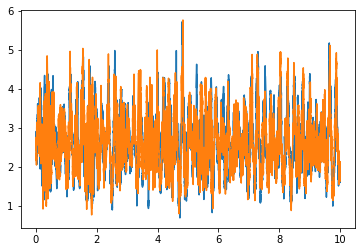

In [129]:
tau = 1e-4
Twnd = 10.
T = np.arange(0, Twnd, tau)
chunksz = round(Twnd/tau)
plt.plot(T, data[:chunksz,0], T, data[:chunksz,1])

In [130]:
Ep = data[:, 0] * np.exp(1j*(data[:,2] + data[:,3]))
Em = data[:, 1] * np.exp(1j*(data[:,2] - data[:,3]))
Ex = (Ep + Em) / np.sqrt(2)
Ey = (Ep - Em) / np.sqrt(2) / 1j

In [131]:
np.array(specsx).shape

(21, 100000)

In [132]:
specsx = []
specsy = []
for i in range(21):
    specsx.append(np.abs(np.fft.fftshift(np.fft.fft(Ex[round(0.2*chunksz*i):round(0.2*chunksz*i)+chunksz])))**2)
    specsy.append(np.abs(np.fft.fftshift(np.fft.fft(Ey[round(0.2*chunksz*i):round(0.2*chunksz*i)+chunksz])))**2)
powspecx = np.mean(specsx, axis=0)
powspecy = np.mean(specsy, axis=0)

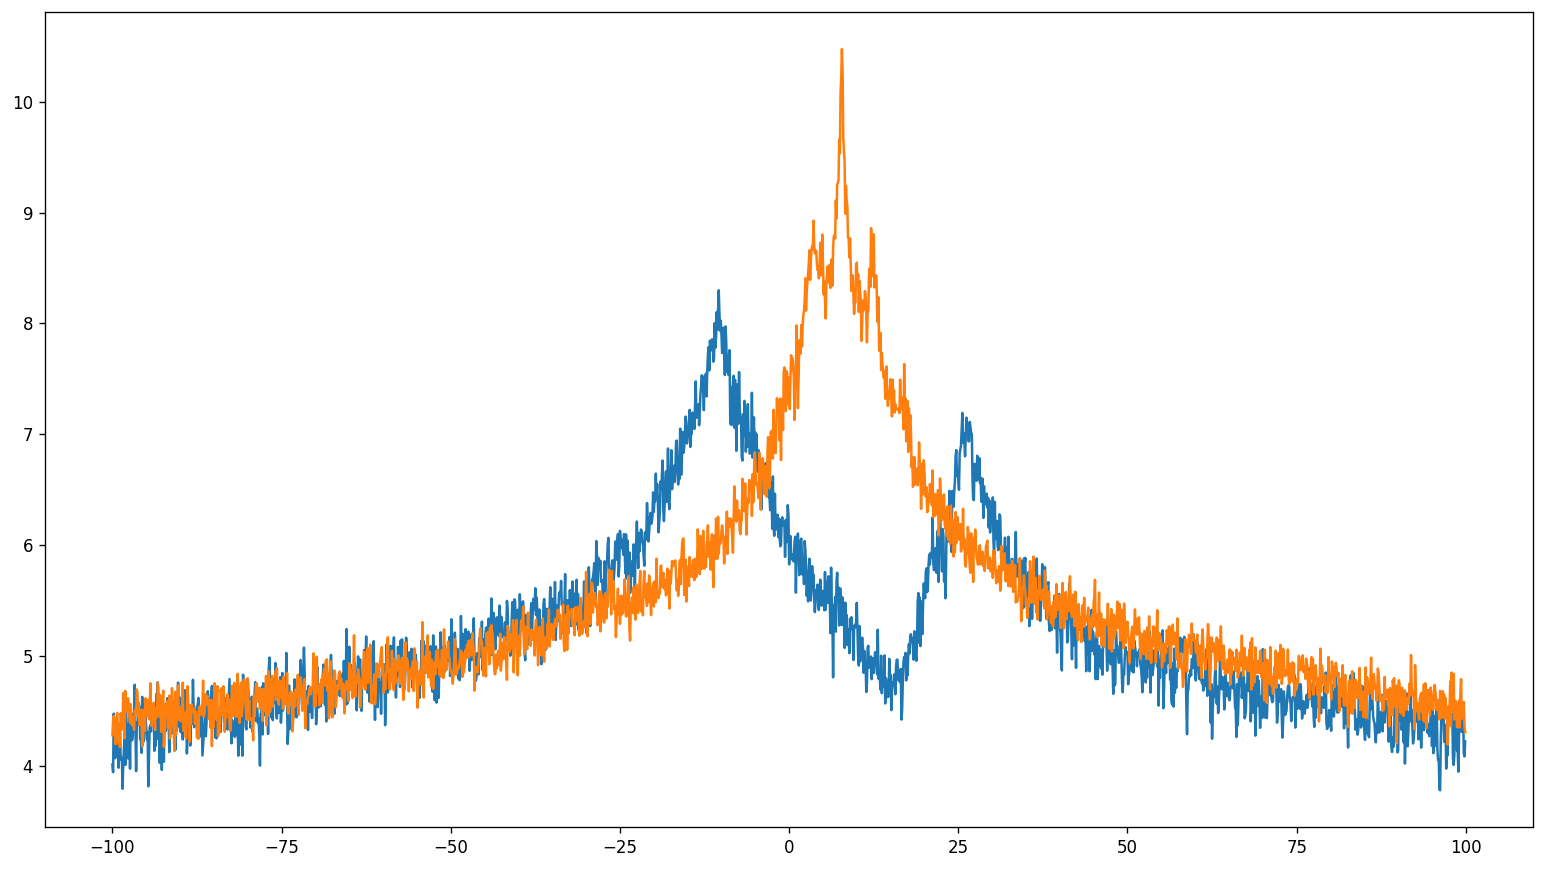

In [133]:
freqs = np.arange(-1/2/tau, 1/2/tau, 1/Twnd)

plt.figure(figsize=(16,9), dpi=120)
WW = 1000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plt.plot(freqs[wnd], np.log10(powspecx[wnd]), freqs[wnd], np.log10(powspecy[wnd]))
plt.show()

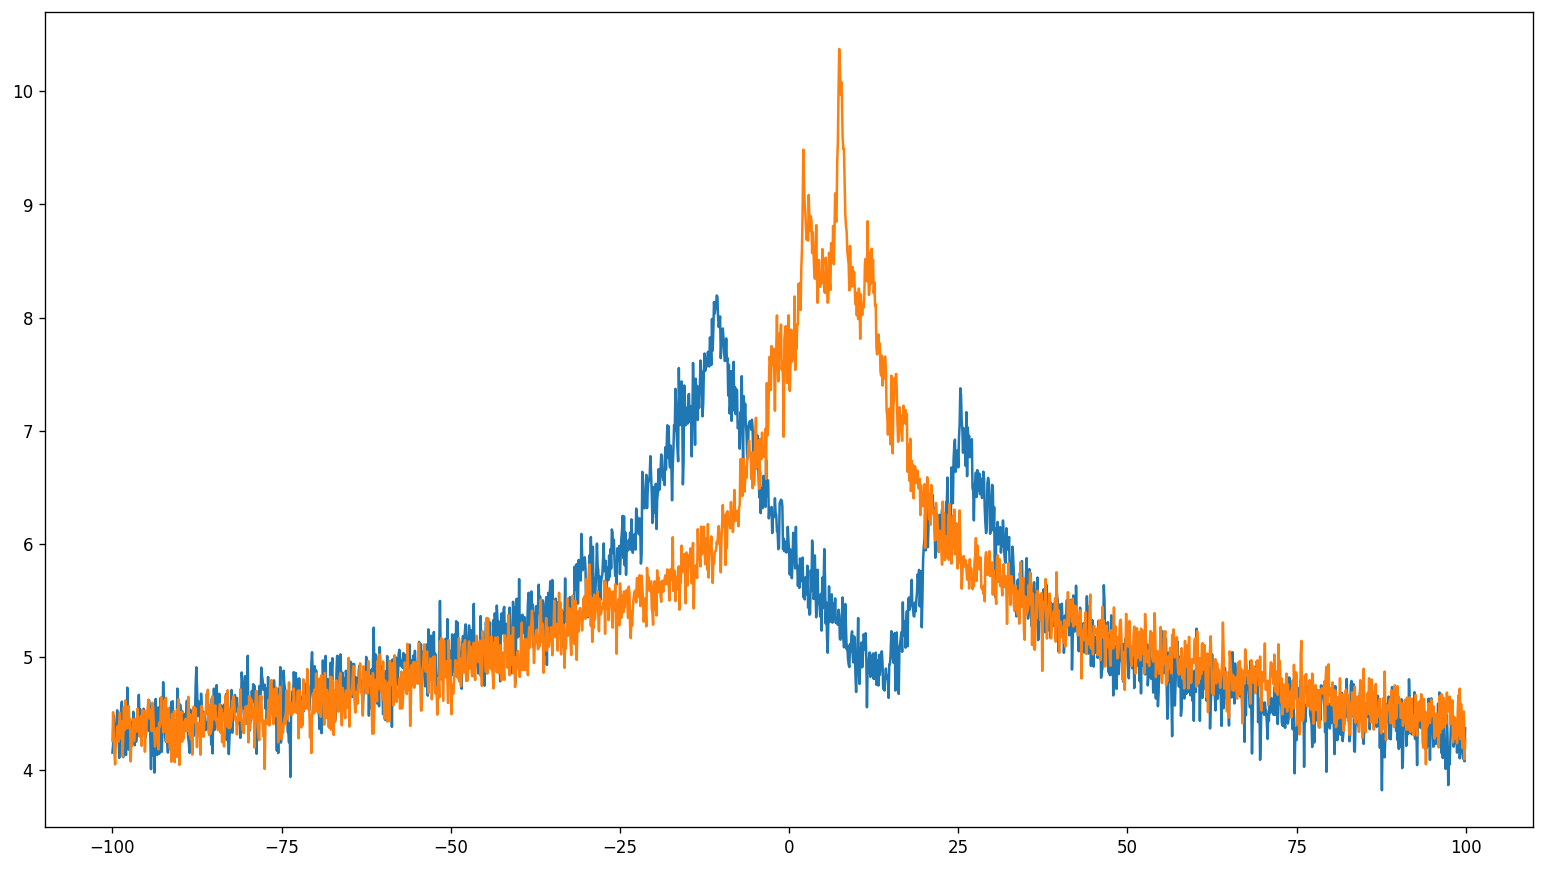

In [115]:
freqs = np.arange(-1/2/tau, 1/2/tau, 1/Twnd)

plt.figure(figsize=(16,9), dpi=120)
WW = 1000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plt.plot(freqs[wnd], np.log10(powspecx[wnd]), freqs[wnd], np.log10(powspecy[wnd]))
plt.show()

In [85]:
wnd

array([49000, 49001, 49002, ..., 50997, 50998, 50999])

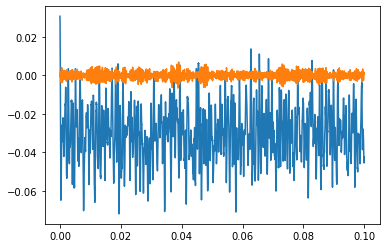

In [18]:
plt.plot(T, data[:,4]-1,T, data[:,5])

In [9]:
N = 1000000
smpl = 2*np.random.random(N)-1
smpl2 = 2*np.random.random(N)-1
R = np.sum(smpl2) / np.sqrt(N/3)
sqsum = np.sum(smpl**2)
out = smpl/np.sqrt(sqsum) * R

(array([ 99891., 100159.,  99896.,  99422., 100143.,  99862., 100359.,
         99734., 100372., 100162.]),
 array([-2.87735421e-03, -2.30188320e-03, -1.72641218e-03, -1.15094116e-03,
        -5.75470142e-04,  8.76311278e-10,  5.75471894e-04,  1.15094291e-03,
         1.72641393e-03,  2.30188495e-03,  2.87735597e-03]),
 <BarContainer object of 10 artists>)

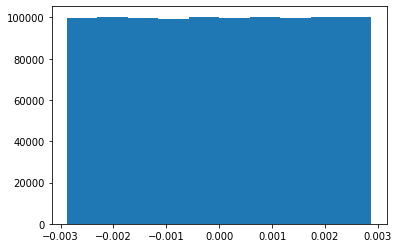

In [24]:
plt.hist(out)

In [22]:
R

1.8610702304524358

In [12]:
stattest = np.loadtxt("output.txt")

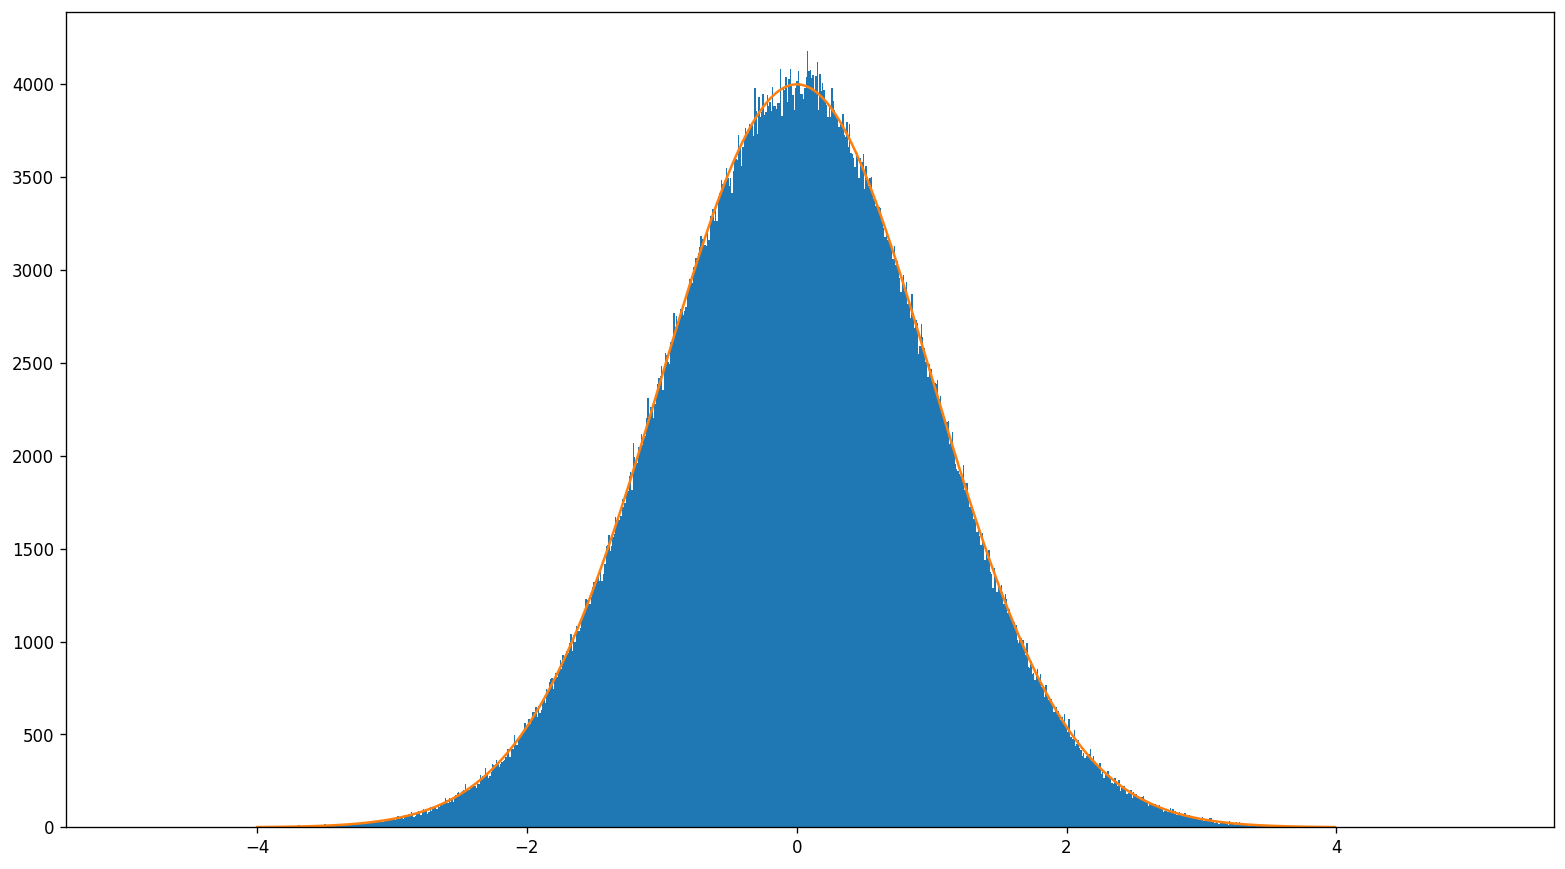

In [27]:
plt.figure(figsize=(16,9), dpi=120)
a,b,_ = plt.hist(stattest, bins=1000)
x = np.arange(-4., 4., 0.01)
y = stattest.shape[0]*(b[1]-b[0])/np.sqrt(np.pi*2)*np.exp(-x**2/2)
plt.plot(x,y)
plt.show()

In [4]:
corr = np.correlate(stattest[0:10000], stattest[0:10000],"same")

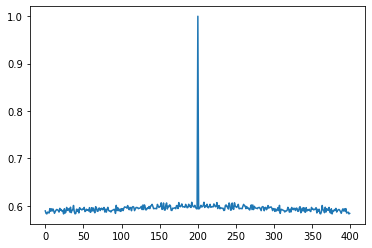

In [8]:
plt.plot(corr[4800:5200]/np.max(corr))